# all the necessary imports

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
# Read the dataset
from tensorflow.examples.tutorials.mnist import input_data
import time
from tqdm import tqdm
import pickle
import imageio
import re

/home/amacs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# read data from mnist dataset

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Discrimator definition

In [3]:
def discriminator(images, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Second convolutional and pool layers
    # This finds 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4
    o = tf.sigmoid(d4)
    
    return o

# Generator Definition

In [4]:
def generator(z, batch_size, z_dim):
    # From z_dim to 56*56 dimension
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    o = tf.nn.tanh(g4)
    return o

# Utility functions

In [5]:
def save_fig(imgs, path, w = 14, h = 14, fig_size=(14, 14), columns = 4, rows = 5):
    assert len(imgs) == columns * rows, "Please check the images"
    fig = plt.figure(figsize=fig_size)
    for i in range(0, columns*rows):
        img = imgs[i]
        fig.add_subplot(rows, columns, i+1)
        if img.ndim == 2:
            plt.gray()
        plt.imshow(img)
    plt.savefig(path)
    plt.close()


def frames_to_gif(directory, output_path="./output.gif"):
    assert os.path.isdir(directory), "Please make sure {} is a folder, and contains images".format(directory)
    images = []
    files = os.listdir(directory)
    ordered_files = sorted(files, key=lambda x: (int(re.sub('\D','',x)),x))
    for filename in ordered_files:
        path = os.path.join(directory, filename)
        images.append(imageio.imread(path))
    imageio.mimsave(output_path, images)

# Define variable scope

In [6]:
z_dimensions = 100
batch_size = 64
tf.reset_default_graph()
# network: generator
with tf.variable_scope("G"):
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    # z_placeholder is for feeding input noise to the generator
    Gz = generator(z_placeholder, batch_size, z_dimensions) 
    # Gz holds the generated images

# network: discriminator
with tf.variable_scope("D"):
    x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
    # x_placeholder is for feeding input images to the discriminator
    Dx = discriminator(x_placeholder) 
    # Dx will hold discriminator prediction probabilities
    # for the real MNIST images
    Dg = discriminator(Gz, reuse=True)
    # Dg will hold discriminator prediction probabilities for generated images

# Loss function

In [7]:
eps = 1e-2
# loss for each network
# maximize 1/m * Σlog(Dx) + 1/m * Σ(1-Dg) = min - 1/m * Σlog(Dx) - 1/m * Σ(1-Dg)
D_loss = tf.reduce_mean(-tf.log(Dx + eps) - tf.log(1 - Dg + eps))
G_loss = tf.reduce_mean(-tf.log(Dg + eps))

# Optimizer

In [8]:
#Get the variables for different network
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Train the discriminator
d_trainer = tf.train.GradientDescentOptimizer(0.0001).minimize(D_loss, var_list=d_vars)

# Train the generator
g_trainer = tf.train.GradientDescentOptimizer(0.0001).minimize(G_loss, var_list=g_vars)

# Other initialization

In [9]:
output_directory = "./MNIST_GAN_results_1000"
# results save folder
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)

# initial 20 random noise images
target_init_z = np.random.normal(0, 1, size=[20, z_dimensions])
train_set = (mnist.train.images - 0.5) / 0.5  # normalization; range: -1 ~ 1

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

# trainign stats
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

saver = tf.train.Saver()
epochs = 1000

# Start training

In [11]:
# Train generator and discriminator together
for i in tqdm(range(1, epochs+1)):
    G_losses = []
    D_losses = []
    for iteration in range(train_set.shape[0] // batch_size):
        with tf.variable_scope("D"):
            real_image_batch = train_set[iteration*batch_size:(iteration+1)*batch_size].reshape([batch_size, 28, 28, 1])
            z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
            
            # Train discriminator
            _, d_loss = sess.run([d_trainer, D_loss],
                                    {x_placeholder: real_image_batch, z_placeholder: z_batch})
            D_losses.append(d_loss)
            
            # Train generator
            z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
            _, g_loss = sess.run([g_trainer, G_loss], feed_dict={z_placeholder: z_batch})
            G_losses.append(g_loss)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    if i % 50 == 0:
        # show generated images
        with tf.variable_scope("G"):
            tf.get_variable_scope().reuse_variables()
            generated_images = generator(z_placeholder, target_init_z.shape[0], z_dimensions)
            images = sess.run(generated_images, {z_placeholder: target_init_z})
            path = os.path.join(output_directory, "epoch_{}.jpg".format(i))
            save_fig(images.squeeze(), path)
        print("Mean Loss for Discriminator:{}, Mean Loss for Generator: {}".format(np.mean(D_losses), np.mean(G_losses)))
saver.save(sess, "./model_1000/model.ckpt")
sess.close()

  5%|▌         | 50/1000 [15:54<5:13:48, 19.82s/it]

Mean Loss for Discriminator:1.0402277708053589, Mean Loss for Generator: 0.9459400177001953


 10%|█         | 100/1000 [31:58<4:56:04, 19.74s/it]

Mean Loss for Discriminator:0.7283501625061035, Mean Loss for Generator: 1.5389714241027832


 15%|█▌        | 150/1000 [48:03<4:39:15, 19.71s/it]

Mean Loss for Discriminator:0.6780683994293213, Mean Loss for Generator: 1.612345814704895


 20%|██        | 200/1000 [1:04:06<4:22:21, 19.68s/it]

Mean Loss for Discriminator:0.6808307766914368, Mean Loss for Generator: 1.628017544746399


 25%|██▌       | 250/1000 [1:20:07<4:05:57, 19.68s/it]

Mean Loss for Discriminator:0.7264381647109985, Mean Loss for Generator: 1.5976718664169312


 30%|███       | 300/1000 [1:36:06<3:48:48, 19.61s/it]

Mean Loss for Discriminator:0.7153699994087219, Mean Loss for Generator: 1.6504563093185425


 35%|███▌      | 350/1000 [1:52:05<3:32:23, 19.61s/it]

Mean Loss for Discriminator:0.6555188298225403, Mean Loss for Generator: 1.7506763935089111


 40%|████      | 400/1000 [2:08:01<3:15:17, 19.53s/it]

Mean Loss for Discriminator:0.6107269525527954, Mean Loss for Generator: 1.849137544631958


 45%|████▌     | 450/1000 [2:23:58<2:59:01, 19.53s/it]

Mean Loss for Discriminator:0.5802996158599854, Mean Loss for Generator: 1.9737799167633057


 50%|█████     | 500/1000 [2:39:52<2:42:49, 19.54s/it]

Mean Loss for Discriminator:0.5433701872825623, Mean Loss for Generator: 2.050025701522827


 55%|█████▌    | 550/1000 [2:55:46<2:26:16, 19.50s/it]

Mean Loss for Discriminator:0.5019587874412537, Mean Loss for Generator: 2.146402359008789


 60%|██████    | 600/1000 [3:11:39<2:09:45, 19.46s/it]

Mean Loss for Discriminator:0.48456451296806335, Mean Loss for Generator: 2.187883138656616


 65%|██████▌   | 650/1000 [3:27:31<1:53:38, 19.48s/it]

Mean Loss for Discriminator:0.45798495411872864, Mean Loss for Generator: 2.2328341007232666


 70%|███████   | 700/1000 [3:43:23<1:37:14, 19.45s/it]

Mean Loss for Discriminator:0.43298688530921936, Mean Loss for Generator: 2.303063154220581


 75%|███████▌  | 750/1000 [3:59:14<1:21:00, 19.44s/it]

Mean Loss for Discriminator:0.4218542277812958, Mean Loss for Generator: 2.3747763633728027


 80%|████████  | 800/1000 [4:15:04<1:04:44, 19.42s/it]

Mean Loss for Discriminator:0.4027394950389862, Mean Loss for Generator: 2.411433458328247


 85%|████████▌ | 850/1000 [4:30:55<48:32, 19.42s/it]  

Mean Loss for Discriminator:0.3920406401157379, Mean Loss for Generator: 2.4680192470550537


 90%|█████████ | 900/1000 [4:46:45<32:26, 19.46s/it]

Mean Loss for Discriminator:0.376052588224411, Mean Loss for Generator: 2.5101349353790283


 95%|█████████▌| 950/1000 [5:02:35<16:09, 19.40s/it]

Mean Loss for Discriminator:0.35777920484542847, Mean Loss for Generator: 2.533843517303467


100%|██████████| 1000/1000 [5:18:24<00:00, 19.45s/it]

Mean Loss for Discriminator:0.3599212169647217, Mean Loss for Generator: 2.515031337738037


In [12]:
frames_to_gif("MNIST_GAN_results_1000")

# Restore 

In [23]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
z_dimensions = 100

In [37]:
batch_size = 1
with tf.variable_scope("G"):
    tf.get_variable_scope().reuse_variables()
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    # z_placeholder is for feeding input noise to the generator
    Gz = generator(z_placeholder, batch_size, z_dimensions) 
    # Gz holds the generated images

In [38]:
saver = tf.train.Saver()

In [39]:
saver.restore(sess, './model_1000/model.ckpt')

INFO:tensorflow:Restoring parameters from ./model_1000/model.ckpt


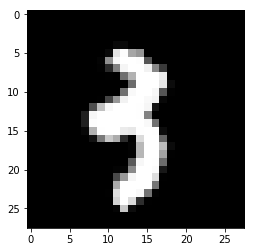

In [41]:
test_z = np.random.normal(0, 1, size=[1, z_dimensions])
with tf.variable_scope("G"):
    tf.get_variable_scope().reuse_variables()
    images = sess.run(Gz, {z_placeholder: test_z})
    plt.imshow(images[0].squeeze(), cmap ='gray')
    plt.show()